# Assignment 3: POS tagging
 
*version 2, since this lab is new for 2020, details/bugs in this lab might be fixed within the first week of publication, you will be notified by email if this happens*
 
For this assignment, you will analyse three different ways of doing POS tagging. The first is a very naive method while the second and third represent different "generations" of methods. It should be said that none of the methods are close to the state-of-the-art for the respective technology, but are implemented more simple and clean for easier analysis. The focus here is not the performance of the specific implemented models but their inner workings.
 
In part 0, some data will be loaded. This part is only there to make the subsequent parts possible and plays no part in the analysis.
 
## Report instructions
 
For each of the POS taggers you should write a short analysis on at most 4 pages (½-1 page per tagger, excluding figures and references) in academic english. You should answer or include the following:
 
1. What are the parameters of the respective taggers?
2. What are the hyperparameters of the respective taggers?
3. How are the above learned from data? Include a short description of the learning algorithms used for the respective taggers.
4. A short description of the prediction algorithms used for the respective taggers.
5. (only for VG) References to the relevant literature.
6. (only for VG) Include illustrations of learning/prediction where applicable.
7. (only for VG) Comment on shortcommings and how to improve the model more in line with the state-of-the-art.
 
## Submission
 
Please make your submission through Studentportalen in pdf format. 
 
The assignment must be solved by each student individually **or** in a pair (given the agreed upon restrictions in partner choice). 
 
## Plagiarism
 
Since this assignment is examined through a report, standard rules for plagiarism apply. However, please discuss the given code with your course mates.

In [1]:
import numpy as np
import time

## Part 0: Loading data from the Brown corpus

The following downloads some data and picks it apart to get it on a standard sklearn form. This is a famous data set that you should know about. You can read more on the dataset at https://en.wikipedia.org/wiki/Brown_Corpus.

In [2]:
import nltk
nltk.download('brown')
from nltk.corpus import brown
nltk.download('universal_tagset')

n_sentences = len(brown.tagged_sents(tagset='universal'))

X = list()
y = list()
for sentence in brown.tagged_sents(tagset='universal'):
  for n, pair in enumerate(sentence):
    word, tag = pair
    if n == 0:
      X.append([word])
      y.append([tag])
    else:
      X[-1].append(word)
      y[-1].append(tag)
assert len(X) == len(y)

print("Found %i sentences with %i instances" % (n_sentences, np.sum([len(x) for x in X])))

[nltk_data] Downloading package brown to /Users/yonwu/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/yonwu/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


Found 57340 sentences with 1161192 instances


Let's look at some examples of the data.

In [3]:
print("Original data example:", brown.tagged_sents(tagset='universal')[0])
print("Processed data example:")
print("x_0: %s" % X[0])
print("y_0: %s" % y[0])

Original data example: [('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]
Processed data example:
x_0: ['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
y_0: ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']


To be able to compare the models, the accuracy and train/test splits are defined here, before the tagger code.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

def tag_accuracy(y, y_hat):
  accuracy = list()
  for u, v in zip(y, y_hat):
    accuracy.append(np.sum([e1==e2 for e1, e2 in zip(u, v)])/len(u))
  return accuracy

## Part 1: A very naive tagger
 
This is a very naive tagger. However, since getting an accuracy above 90% is not that hard for POS tagging, this can still impress someone not familiar with the problem formulation.

In [5]:
class NaiveTagger:
  def __init__(self):
    """A very naive POS tagger"""
    pass
  
  def fit(self, X, y):
    self._unique_words = list()
    for x in X:
      self._unique_words.extend(x)
    self._unique_words = list(set(self._unique_words))

    self._unique_tags = list()
    for e in y:
      self._unique_tags.extend(e)
    self._unique_tags = list(set(self._unique_tags))

    self._unique_words_lut = dict()
    for i, word in enumerate(self._unique_words):
      self._unique_words_lut[word] = i

    self._unique_tags_lut = dict()
    for i, tag in enumerate(self._unique_tags):
      self._unique_tags_lut[tag] = i

    self.frequencies = np.zeros((len(self._unique_words), len(self._unique_tags)), dtype=np.int)

    for words, tags in zip(X, y):
      for word, tag in zip(words, tags):
        self.frequencies[self._unique_words_lut[word], self._unique_tags_lut[tag]] += 1

  def predict(self, X):
    majority_vote = naive_tagger._unique_tags[np.argmax(np.sum(naive_tagger.frequencies, axis=0))]
    ret = list()
    for words in X:
      tags = list()
      for word in words:
        if word in self._unique_words_lut:
          tags.append(self._unique_tags[np.argmax(self.frequencies[self._unique_words_lut[word], :])])
        else:
          tags.append(majority_vote)
      ret.append(tags)
    return ret

In [7]:
naive_tagger._unique_tags[np.argmax(np.sum(naive_tagger.frequencies, axis=0))]

'NOUN'

In [6]:
naive_tagger = NaiveTagger()
naive_tagger.fit(X_train, y_train)

y_hat = naive_tagger.predict(X_test)

accuracy = tag_accuracy(y_test, y_hat)
print("Mean accuracy: %.1f%% [std %.1f%%]" % (100*np.mean(accuracy), 100*np.std(accuracy)))

Mean accuracy: 94.6% [std 6.8%]


## Part 2: Hidden markov model

The implementation of the decoding follows the wikipedia description
https://en.wikipedia.org/wiki/Viterbi_algorithm . For a more in depth desxcrtiption of the inner workings of an HMM, Rabiner's classic tutorial paper is a good start.

L. R. Rabiner, "*A tutorial on hidden Markov models and selected applications in speech recognition,*" in Proceedings of the IEEE, vol. 77, no. 2, pp. 257-286, Feb. 1989.
doi: 10.1109/5.18626


For the following model to work, we need to load the cython extension.


In [8]:
%load_ext cython

In [9]:
%%cython
import numpy as np

class POStagger:
  def __init__(self):
    """Simple HMM POS-tagger"""
    pass

  def fit(self, X, y):
    # Find unique words and tags
    unique_words = list()
    for words in X:
        unique_words.extend(words)
    unique_tags = list()
    for tags in y:
      unique_tags.extend(tags)
    self._unique_words = set(unique_words)
    self._unique_tags = set(unique_tags)
    # Making LUTs for indexing tags and words
    self._words_lut = dict()
    for n, word in enumerate(self._unique_words):
      self._words_lut[word] = n
    self._words_lut_inv = [None]*len(self._words_lut)
    for word, n in self._words_lut.items():
      self._words_lut_inv[n] = word
    self._tags_lut = dict()
    for n, tag in enumerate(self._unique_tags):
      self._tags_lut[tag] = n
    self._tags_lut_inv = [None]*len(self._tags_lut)
    for tag, n in self._tags_lut.items():
      self._tags_lut_inv[n] = tag
    assert np.all([e is not None for e in self._words_lut_inv])
    assert np.all([e is not None for e in self._tags_lut_inv])
    # print("Tags:", self._tags_lut)
    # print("Tags inverse:", self._tags_lut_inv)
    # print("Words:", repr(self._words_lut))
    # print("Words inverse:", repr(self._words_lut_inv))
    # Allocate matrices for key statistics (pi, A, B)
    self.n_states_ = len(self._tags_lut)
    self.n_words_ = len(self._words_lut)
    self.pi = np.zeros(self.n_states_)
    self.A = np.zeros((self.n_states_, self.n_states_))
    self.B = np.zeros((self.n_states_, self.n_words_))
    # Set prior
    self.pi[:] = 1/self.n_states_
    self.A[:] = 1/self.n_states_
    self.B[:] = 1/self.n_words_
    # Count occurences
    for words, tags in zip(X, y):
      for n, word, tag in zip(range(len(words)), words, tags):
        if n == 0:
          # Record start states 
          self.pi[self._tags_lut[tag]] += 1
        else:
          # Record tag transitions
          self.A[self._tags_lut[last_tag], self._tags_lut[tag]] += 1
        # Record word given tag occurences
        self.B[self._tags_lut[tag], self._words_lut[word]] += 1
        last_tag = tag
    # Normalize probabilities
    self.pi /= np.sum(self.pi)
    for i in range(self.A.shape[0]):
      self.A[i, :] /= np.sum(self.A[i, :])
    for i in range(self.B.shape[0]):
      self.B[i, :] /= np.sum(self.B[i, :])

  def predict(self, X):
    assert type(X) == list
    assert type(X[0]) == list
    return [t[0] for t in map(self._predict, X)]

  def _predict(self, sentence):
    assert type(sentence) == list
    cdef int i, j, k
    cdef int n_states = self.n_states_
    # Forward pass
    T1 = np.zeros((n_states, len(sentence)))
    cdef double[:,:] T1_memview = T1
    T2 = np.zeros(T1.shape, dtype=np.intc)
    cdef int[:,:] T2_memview = T2
    cdef double[:] pi_memview = self.pi
    cdef double[:,:] A_memview = self.A
    cdef double[:,:] B_memview = self.B
    cdef double p_max, w
    B_column = np.zeros(n_states, dtype=np.double)
    cdef double[:] B_column_memview = B_column
    for j, word in enumerate(sentence):
      if word in self._words_lut:
        word_idx = self._words_lut[word]
        for k in range(n_states):
          B_column_memview[k] = B_memview[k, word_idx]
      else:
        # If word is not in the training data, fall back to uniform probability
        w = 1/n_states
        for k in range(n_states):
          B_column_memview[k] = w
      # Special case for the first word in the sentence
      if j == 0:
        for i in range(n_states):
          T1_memview[i, j] = pi_memview[i]*B_column_memview[i]
      else:
        for i in range(n_states):
          p_max = 0
          for k in range(n_states):
            w = T1_memview[k, j-1]*A_memview[k, i]*B_column_memview[i]
            if w > p_max:
              p_max = w
              T1_memview[i, j] = w
              T2_memview[i, j] = k
    # Backward pass
    traceback = [np.argmax(T1[:, -1])]
    for i in range(len(sentence)-1, 0, -1):
      traceback.insert(0, T2[traceback[0], i])
    # print(output)
    assert len(traceback) == len(sentence)
    # Translate state numbers to tags and append to output
    return [self._tags_lut_inv[i] for i in traceback], T1, T2

In [10]:
tagger = POStagger()

t = time.time()
tagger.fit(X_train, y_train)
print("Training finished after %.1f seconds" % (time.time()-t))

t = time.time()
y_hat = tagger.predict(X_test)
t = time.time()-t
print("Prediction finished after %.1f seconds (%.1f μs/sentence)" % (t, 1e6*t/len(X_test)))

accuracy = tag_accuracy(y_test, y_hat)
print("Mean accuracy: %.1f%% [std %.1f%%]" % (100*np.mean(accuracy), 100*np.std(accuracy)))

Training finished after 1.5 seconds
Prediction finished after 0.4 seconds (35.8 μs/sentence)
Mean accuracy: 95.7% [std 7.1%]


The following is the code for illustrating the viterbi algorithm used in the slides.

/Users/yonwu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


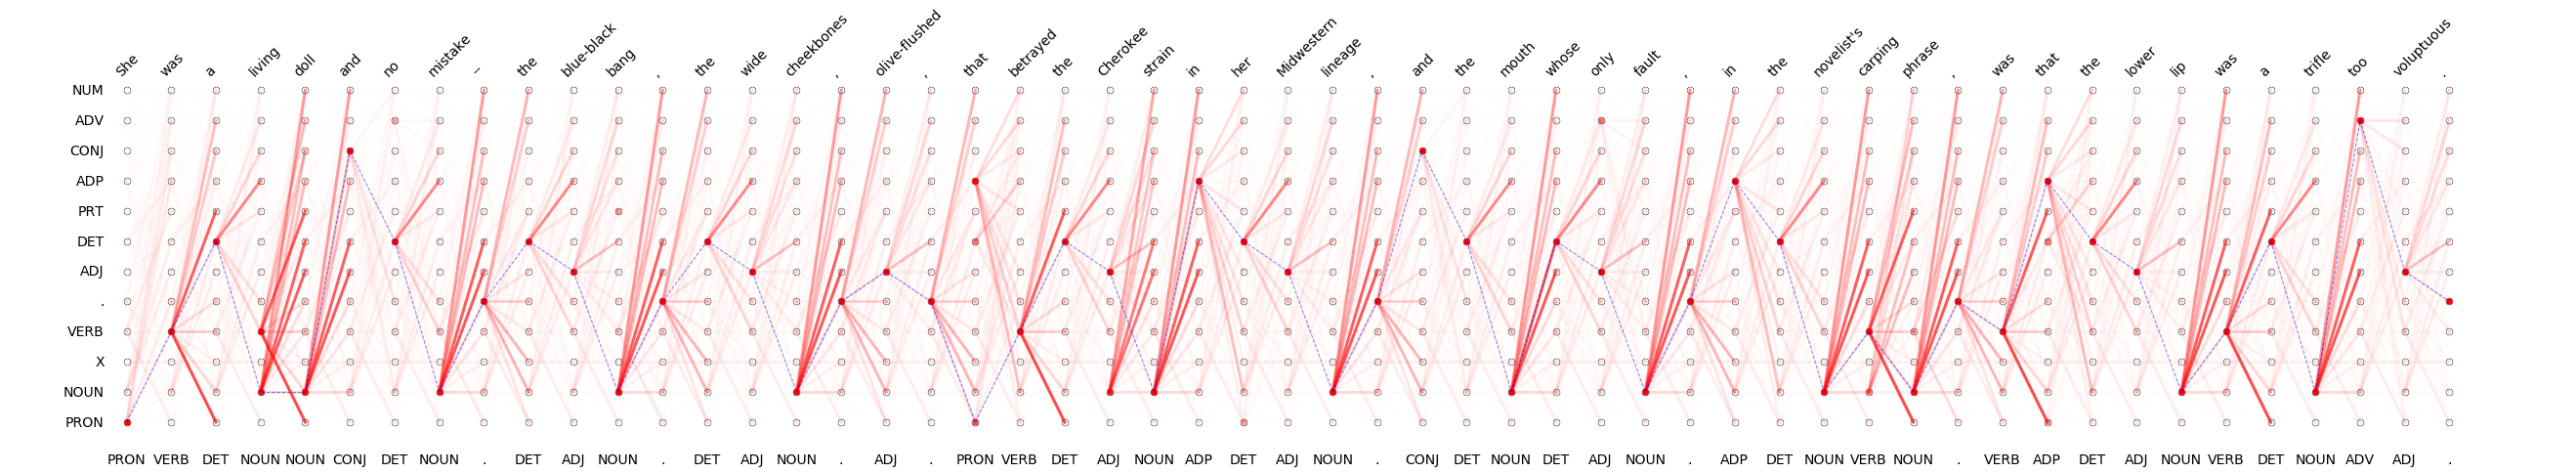

In [11]:
sentence = X[-2]
# tags = y[-1]
forward_pass = None
backward_pass = None
# def show_trellis(tagger, sentence, tags, forward_pass = None, backward_pass = None):

decoded_tags, T1, T2 = tagger._predict(sentence)
if forward_pass is None:
  forward_pass = list(range(len(T1[0])))
elif type(forward_pass) is int:
  forward_pass = list(range(forward_pass))
assert type(forward_pass) is list
if backward_pass is None:
  backward_pass = list(range(len(T1[0])))
elif type(backward_pass) is int:
  backward_pass = list(range(backward_pass, len(sentence)))
assert type(backward_pass) is list

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(int(len(sentence)*.9), int(tagger.n_states_*.6)))
ax = fig.add_subplot(1, 1, 1)
ax.invert_yaxis()

# Forward pass lines
for j, word in enumerate(sentence):
  if j in forward_pass and j > 0:
    w = np.asarray([T1[k][j-1] for k in range(tagger.n_states_)])
    w = .9*w/np.max(w) + .1
    for i in range(tagger.n_states_):
      for k in range(tagger.n_states_):
        ax.plot([j, j-1], [i, k], 'r-', linewidth=3, alpha=w[k]*tagger.A[i][k])
# Plot the base
for i, state in enumerate(tagger._tags_lut_inv):
  ax.text(-.5, i, state, fontsize=14, horizontalalignment='right', verticalalignment='center')
  for j, word in enumerate(sentence):
    if i == 0:
      ax.text(j-.3, -.5, word, size=14, horizontalalignment='left', rotation=45)
    ax.scatter(j, i, c='k', s=40, marker='o')
    ax.scatter(j, i, c='w', s=30, marker='o')
ax.axis('off')
# Forward pass dots
for j, word in enumerate(sentence):
  w = np.asarray([T1[i][j] for i in range(tagger.n_states_)])
  w = w/np.max(w)
  if j in forward_pass:
    for i, state in enumerate(tagger._tags_lut_inv):
      ax.scatter(j, i, c='r', s=30, marker='o', alpha=w[i])
# Backward pass lines
i = np.argmax([T1[i][-1] for i in range(tagger.n_states_)])
for j in range(len(sentence)-1, -1, -1):
  if j in backward_pass and j > 0:
    ax.plot([j-1, j], [T2[i][j], i], 'b--', linewidth=1, alpha=.5)
  if j in backward_pass:
    ax.text(j, tagger.n_states_, tagger._tags_lut_inv[i], fontsize=14, horizontalalignment='center', verticalalignment='top')
  if j > 0:
    i = T2[i][j]
fig.show()

## Part 3: LSTM based tagger

This is neural tagger using the LSTM cell for tagging sentences. This code is largely taken from the pyTorch tutorials.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Converts text tokens to numbers
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

# Preparing using all the data since there is no 'unknown' symbol implemented yet 
word_to_ix = dict()
tag_to_ix = dict()
for sent, tags in zip(X, y):
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)
print(word_to_ix)
print(tag_to_ix)

# These will usually be 32 or 64 dimensional.
EMBEDDING_DIM = 32
HIDDEN_DIM = 32

{'The': 0, 'Fulton': 1, 'County': 2, 'Grand': 3, 'Jury': 4, 'said': 5, 'Friday': 6, 'an': 7, 'investigation': 8, 'of': 9, "Atlanta's": 10, 'recent': 11, 'primary': 12, 'election': 13, 'produced': 14, '``': 15, 'no': 16, 'evidence': 17, "''": 18, 'that': 19, 'any': 20, 'irregularities': 21, 'took': 22, 'place': 23, '.': 24, 'jury': 25, 'further': 26, 'in': 27, 'term-end': 28, 'presentments': 29, 'the': 30, 'City': 31, 'Executive': 32, 'Committee': 33, ',': 34, 'which': 35, 'had': 36, 'over-all': 37, 'charge': 38, 'deserves': 39, 'praise': 40, 'and': 41, 'thanks': 42, 'Atlanta': 43, 'for': 44, 'manner': 45, 'was': 46, 'conducted': 47, 'September-October': 48, 'term': 49, 'been': 50, 'charged': 51, 'by': 52, 'Superior': 53, 'Court': 54, 'Judge': 55, 'Durwood': 56, 'Pye': 57, 'to': 58, 'investigate': 59, 'reports': 60, 'possible': 61, 'hard-fought': 62, 'won': 63, 'Mayor-nominate': 64, 'Ivan': 65, 'Allen': 66, 'Jr.': 67, 'Only': 68, 'a': 69, 'relative': 70, 'handful': 71, 'such': 72, 'rece

In [15]:
class LSTMTagger(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
    """An LSTM based tagger"""
    # We need to call the class we are inheriting from
    super(LSTMTagger, self).__init__()
    # This simply stores the parameter
    self.hidden_dim = hidden_dim
    # Create the vector space for the input words
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
    # The LSTM takes word embeddings as inputs, and outputs hidden states
    # with dimensionality hidden_dim.
    self.lstm = nn.LSTM(embedding_dim, hidden_dim)
    # The linear layer that maps from hidden state space to tag space
    self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

  def forward(self, sentence):
    embeds = self.word_embeddings(sentence)
    lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

# This instantiates the network
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
print(model)

LSTMTagger(
  (word_embeddings): Embedding(56057, 32)
  (lstm): LSTM(32, 32)
  (hidden2tag): Linear(in_features=32, out_features=12, bias=True)
)


The training is defined below. Again, there are more efficient ways of doing this but few that are more clear.

In [16]:
# We choose a loss function that fits our choice of output layer and data
loss_function = nn.NLLLoss()

# We give the optimiser the parameters to work with and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.1)

loss_for_plotting = list()

for epoch in range(50):
  # For collecting the gradient from each training example, we first need to
  # set the gradients from the last iteration to zero.
  model.zero_grad()
  # Now for looping over the training data
  for sentence, tags in zip(X_train[:500], y_train[:500]):
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    # model.zero_grad()

    # Step 2. Get our inputs ready for the network, that is, turn them into
    # Tensors of word indices.
    sentence_in = prepare_sequence(sentence, word_to_ix)
    targets = prepare_sequence(tags, tag_to_ix)

    # Step 3. Run our forward pass.
    tag_scores = model(sentence_in)

    # Step 4. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = loss_function(tag_scores, targets)
    loss.backward()
  optimizer.step()
  loss_for_plotting.append(float(loss))
  if (epoch % 5) == 0:
    print("Epoch %i: loss %.3f" % (epoch, loss))

Epoch 0: loss 2.463
Epoch 5: loss 9.601
Epoch 10: loss 7.192
Epoch 15: loss 15.230
Epoch 20: loss 1.311
Epoch 25: loss 0.623
Epoch 30: loss 0.089
Epoch 35: loss 0.019
Epoch 40: loss 0.081
Epoch 45: loss 0.015


We can plot the stored loss over epochs.

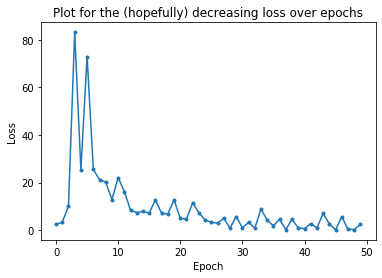

In [14]:
plt.figure()
plt.title("Plot for the (hopefully) decreasing loss over epochs")
plt.plot(loss_for_plotting, '.-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


Now for predicting from the model.

In [17]:
# The model predicts indeces for tags and we want tags in plain text for y_hat
ix_to_tag = [None]*len(tag_to_ix.keys())
for tag, ix in tag_to_ix.items():
  ix_to_tag[ix] = tag

y_hat = list()

# See what the scores are after training
with torch.no_grad():
  for sentence in X_test[:200]:
    inputs = prepare_sequence(sentence, word_to_ix)
    tag_scores = model(inputs)
    # The tag scorse in a matrix with the probabilities for the tags in its rows
    y_hat.append([ix_to_tag[np.argmax(tag_scores[i, :])] for i in range(tag_scores.shape[0])])

accuracy = tag_accuracy(y_test[:200], y_hat)
print("Mean accuracy: %.1f%% [std %.1f%%]" % (100*np.mean(accuracy), 100*np.std(accuracy)))

Mean accuracy: 60.7% [std 12.9%]


The result is underwhelming. This is because the model is not tuned properly and the training data is small.